In [1]:
import numpy as np
import scipy.misc as misc
# import PIL.ImageDraw
import random
# from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
# from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import os
import random
# import scipy.misc
# import tensorflow as tf
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Functions

In [3]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

# Update the weights of the SOM cells when given a single training example
# and the model parameters along with BMU coordinates as a tuple
def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        random.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM

import scipy
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

import sklearn

def euclidean(a, b):
    return np.linalg.norm(a-b)

def u_matrix(lattice):

    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += euclidean(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += euclidean(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += euclidean(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

# Vectorizing

In [4]:
with open('Topic_paragraphs_strike', 'rb') as pickleFile:
    Topic_paragraphs = pickle. load(pickleFile)

In [5]:
print(len(Topic_paragraphs))
print(Topic_paragraphs[3985])

5000
 Philip Randolph wrote in The Messenger, “The Negroes and the Industrial Workers of the World have interests not only in common, but interests that are identical.” The IWW, whose members are called “Wob- blies,” is an interracial revolutionary union founded in 1905 in Chicago that adopted a class struggle approach to organizing through direct action and the strike weapon, striving towards class consciousness and the general strike, with the ultimate goal being the creation of a classless society.


In [6]:
# Select top words based on TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(Topic_paragraphs)

In [7]:
# Number of top words
num_top_words = 2000

In [8]:
feature_names = vectorizer.get_feature_names_out()
top_indices = tfidf_matrix.toarray()[0].argsort()[-num_top_words:]
selected_words = [feature_names[i] for i in top_indices]

# Doc2Vec

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abdulmù\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
# This block takes 10 min to run

# Preprocess the data
tagged_data = [TaggedDocument(words=word_tokenize(sentence.lower()), tags=[str(i)]) for i, sentence in enumerate(Topic_paragraphs)]

# Train Doc2Vec model
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha,
                min_alpha=0.00025,
                min_count=1,
                dm =1)

model.build_vocab(tagged_data)

# for epoch in range(max_epochs):
#     model.train(tagged_data,
#                 total_examples=model.corpus_count,
#                 epochs=model.epochs)
#     # decrease the learning rate
#     model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha



In [83]:
# Infer vectors for each sentence
vectors = [model.infer_vector(word_tokenize(sentence.lower())) for sentence in Topic_paragraphs]

In [87]:
len(vectors)

5000

In [88]:
feature_Text = []
for i in range(len(vectors)):
    featureText = {}
    try:
      featureText['text'] = selected_words[i]
    except:
      continue

    featureText['feature'] = vectors[i]
    feature_Text.append(featureText)

In [14]:
# with open('vectors_Strike.obj', 'wb') as f:
#   pickle.dump(vectors, f)


# with open('/content/drive/MyDrive/Colab Notebooks/Vectors/vectors_Strike.obj', 'rb') as pickleFile:
#   vectors = pickle. load(pickleFile)

# SOM

In [104]:
# Initialize SOM grid dimensions
m = 20
n = 20

# Number of training examples
# n_x = 2000

# Initialize training data
train_data = vectors

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

In [105]:
# # Train the SOM
# epochs = 100
# fig, ax = plt.subplots(
#     nrows=1, ncols=4, figsize=(15, 3.5),
#     subplot_kw=dict(xticks=[], yticks=[]))
# total_epochs = 0
# SOMS = []
# for epochs_per_iter, i in zip([4, 40, 60, 100], range(4)):
#     total_epochs += epochs_per_iter
#     SOM = train_SOM(SOM, train_data, learn_rate=.05, radius_sq=12, epochs=epochs_per_iter)
#     SOMS.append(SOM)
#     QE = round(calculateQE(SOM, train_data), 4)
#     TE = round(calculateTE(SOM, train_data), 4)

#     ax[i].imshow(u_matrix(SOM))
#     ax[i].title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# Save/Import Trained SOM

In [106]:
# with open('trained_SOM_Strike.obj', 'wb') as f:
#   pickle.dump(SOM, f)

with open('trained_SOM_Strike.obj', 'rb') as pickleFile:
  SOM = pickle. load(pickleFile)

# U-Matrix

In [107]:
u_matrix_values = u_matrix(SOM)
QE = round(calculateQE(SOM, train_data), 4)
TE = round(calculateTE(SOM, train_data), 4)

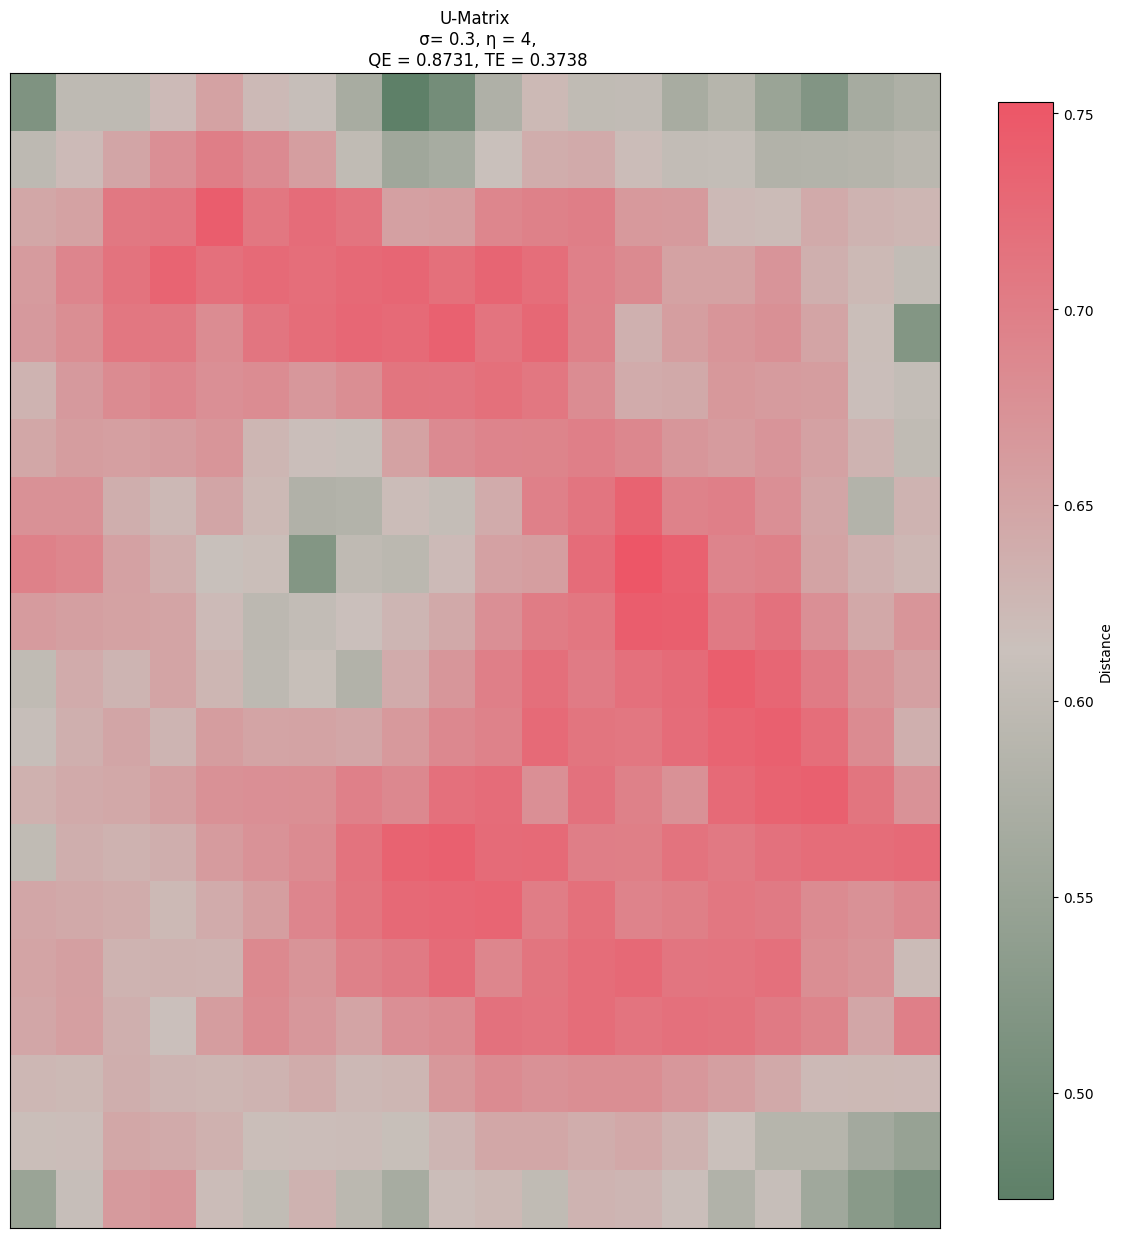

In [108]:
plt.figure(figsize=(15, 15))
colors = [(0, "#5E8068"), (.5, "#CAC1BC"), (1, "#ED5667")] # "#ED5667"), (.5, "#CAC1BC"), (1, "#5E8068",,,, (0, "#5673ed"), (.5, "#bdb9ca"), (1, "#80655e")
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [109]:
# Initialize an empty dictionary to store sentences associated with each neuron
neuron_sentence_mapping = {(i, j): [] for i in range(SOM.shape[0]) for j in range(SOM.shape[1])}


In [110]:
# Iterate through each sentence and find its BMU, then append it to the corresponding neuron's list
for idx, sentence in enumerate(Topic_paragraphs):
    vector = vectors[idx]
    bmu = find_BMU(SOM, vector)
    neuron_sentence_mapping[bmu].append(sentence)

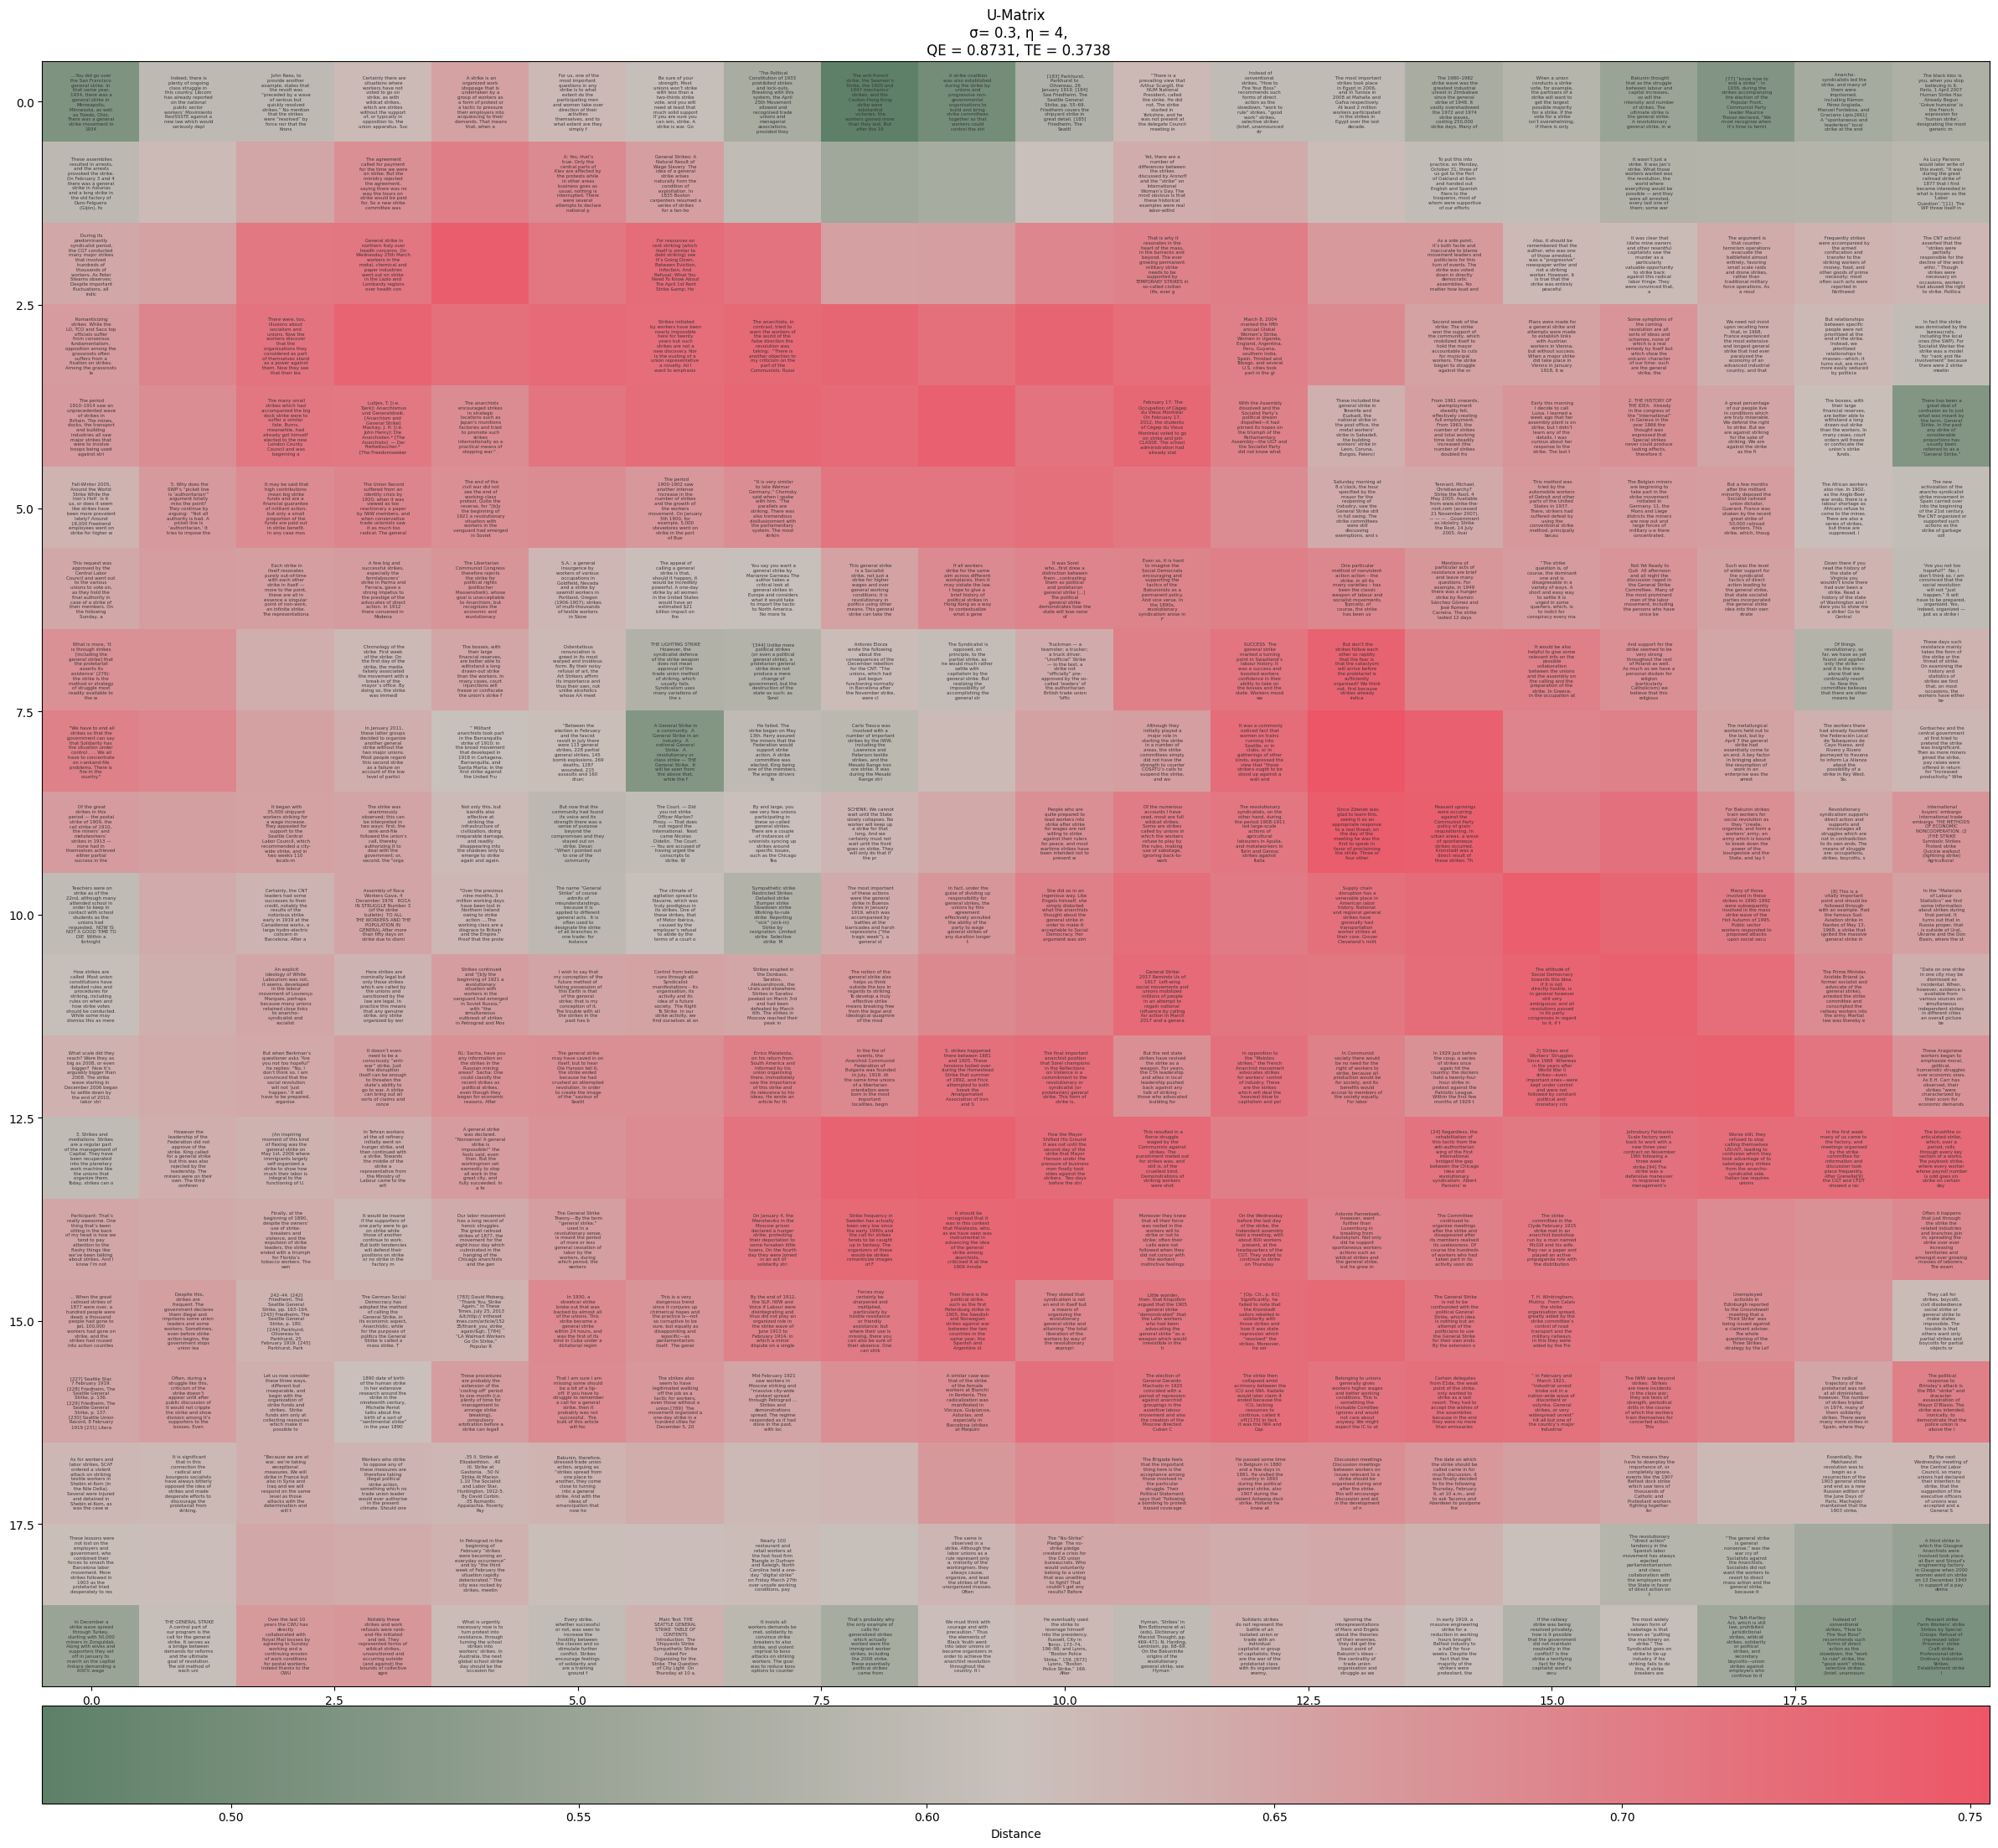

In [111]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(30, 30))
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 4
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:200]  # Take the first 100 characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

# plt.savefig('SOM_Strike.pdf', format='pdf')

# Show the plot
plt.show()

# Query Search: One Word

In [25]:
# Print how many words in each cell

neuron_sentence_mapping = {}

for i in range(SOM.shape[0]):
  for j in range(SOM.shape[1]):
    neuron_sentence_mapping[(i, j)] = []

for word, vector in zip(Topic_paragraphs, vectors):
  bmu = find_BMU(SOM, vector)
  neuron_sentence_mapping[bmu].append(word)

for neuron, words in neuron_sentence_mapping.items():
  print(f"Neuron {neuron} has {len(words)} words.")

Neuron (0, 0) has 319 words.
Neuron (0, 1) has 1 words.
Neuron (0, 2) has 13 words.
Neuron (0, 3) has 30 words.
Neuron (0, 4) has 24 words.
Neuron (0, 5) has 20 words.
Neuron (0, 6) has 28 words.
Neuron (0, 7) has 60 words.
Neuron (0, 8) has 86 words.
Neuron (0, 9) has 68 words.
Neuron (0, 10) has 53 words.
Neuron (0, 11) has 39 words.
Neuron (0, 12) has 40 words.
Neuron (0, 13) has 52 words.
Neuron (0, 14) has 66 words.
Neuron (0, 15) has 45 words.
Neuron (0, 16) has 51 words.
Neuron (0, 17) has 44 words.
Neuron (0, 18) has 18 words.
Neuron (0, 19) has 168 words.
Neuron (1, 0) has 36 words.
Neuron (1, 1) has 0 words.
Neuron (1, 2) has 0 words.
Neuron (1, 3) has 2 words.
Neuron (1, 4) has 0 words.
Neuron (1, 5) has 1 words.
Neuron (1, 6) has 1 words.
Neuron (1, 7) has 0 words.
Neuron (1, 8) has 0 words.
Neuron (1, 9) has 0 words.
Neuron (1, 10) has 0 words.
Neuron (1, 11) has 8 words.
Neuron (1, 12) has 0 words.
Neuron (1, 13) has 0 words.
Neuron (1, 14) has 2 words.
Neuron (1, 15) has

In [26]:
def query_word(SOM, model, word, neuron_sentence_mapping):
    if word in model.wv:
        vector = model.wv[word]
        bmu = find_BMU(SOM, vector)
        return bmu, neuron_sentence_mapping.get(bmu, [])
    else:
        return None, []

def query_words(SOM, model, words, neuron_sentence_mapping):
    vectors = []
    for word in words:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        vectors_matrix = np.array(vectors)  # Convert vectors to NumPy array
        avg_vector = np.mean(vectors_matrix, axis=0)  # Compute average vector
        bmu = find_BMU(SOM, avg_vector)  # Find BMU
        return bmu, neuron_sentence_mapping.get(bmu, [])
    else:
        return None, []

In [27]:
word_to_query = 'government'
bmu, related_words = query_word(SOM, model, word_to_query, neuron_sentence_mapping)
print(f"BMU for '{word_to_query}': {bmu}, Related words: {related_words}")

BMU for 'government': (19, 2), Related words: [' Over the last 10 years the CWU has directly collaborated with Royal Mail bosses by agreeing to Sunday working and a continuing erosion of work conditions for postal workers. Indeed thanks to the CWU productivity — read more efficient exploitation of the workforce — has increased by more than 60%. During the strikes, continuing CWU sabotage continued when it issued a circular telling postal workers not involved in the strike ballot to cross picket lines. This involved mainly part-time casuals, although some full-time workers scabbed as well. The CWU told those posties who had begun their shifts before the start of the strike at midnight to continue working to the end of their shift. The official union strike leaflet handed out said that the postal workers “didn’t want to be out on strike”! ', ' “Consider yourself how foolish and inefficient is the present form of labour organisation in which one trade or craft may be on strike while the o

In [28]:
word_to_query = 'anarchy'
bmu, related_words = query_word(SOM, model, word_to_query, neuron_sentence_mapping)
print(f"BMU for '{word_to_query}': {bmu}, Related words: {related_words}")

BMU for 'anarchy': (7, 6), Related words: [' THE LIGHTING STRIKE  However, the syndicalist defence of the strike weapon does not mean approval of the trade union method of striking, which usually fails. Syndicalism uses many variations of the strike, but it is possible here to mention only a few. ', ' The ILA encouraged scabbing on the strike and the employers locked out all IWW members. The strike collapsed with much bitterness. Fletcher criticized the strike as being the result of “Foot Loose Wobblies.', ' S — And the collective actions, what kind of actions were they, hunger strike, patio strikes etc?  L — Hunger strikes were mainly about petitions, the problem was that at the same time, there were some prisoners who thought that those actions were not going to have any effect.', ' “As we saw with the current mass teachers strikes, which can be seen as literal general strikes across trade lines, collective and communal mutual aid and support from both picketers and community members

# Query Search: Sentences

In [29]:
def vectorize_sentence(sentence, model):
    """
    Vectorizes a sentence by averaging the word vectors of the words present in the sentence.
    """
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return None

def query_sentence(SOM, model, sentence_vector, neuron_sentence_mapping):
    """
    Finds the Best Matching Unit (BMU) for a sentence vector and returns related information.
    """
    if sentence_vector is not None:
        bmu = find_BMU(SOM, sentence_vector)
        return bmu, neuron_sentence_mapping.get(bmu, [])
    else:
        return None, []

def query_sentences(SOM, model, sentences, neuron_sentence_mapping):
    """
    Finds the Best Matching Unit (BMU) for a list of sentences and returns related information.
    """
    vectors = [vectorize_sentence(sentence, model) for sentence in sentences]
    vectors = [vector for vector in vectors if vector is not None]  # Remove None entries
    if vectors:
        vectors_matrix = np.array(vectors)  # Convert vectors to NumPy array
        avg_vector = np.mean(vectors_matrix, axis=0)  # Compute average vector
        bmu = find_BMU(SOM, avg_vector)  # Find BMU
        return bmu, neuron_sentence_mapping.get(bmu, [])
    else:
        return None, []

In [36]:
# Example usage:
sentence_to_query = "The right of workers to strike in defence of their interests is recognised."
sentence_vector = vectorize_sentence(sentence_to_query, model)
bmu, related_sentences = query_sentence(SOM, model, sentence_vector, neuron_sentence_mapping)
print(f"BMU for '{sentence_to_query}': {bmu}, Related sentences: {related_sentences}")

BMU for 'The right of workers to strike in defence of their interests is recognised.': (9, 10), Related sentences: [' People who are quite prepared to lead workers into strike after strike for wages are not willing to strike against their rulers for peace, and most wartime strikes have been intended not to prevent war but to prevent rulers and employers from using war as an excuse to increase discipline or decrease wages.', ' While the model of the strike is explicitly referenced in the “Critique of Violence,” it is absent—rather conspicuously—from the “Concept of History.” In the former, he writes about the strike which appears in the class struggle as a form of violence. He distinguishes between different aspects. On the one hand is the strike as extortion—violence used by labor as a means toward securing an end, which the state sanctions as a legal right in order to “forestall violent actions [such as the burning of factories] the state is afraid to oppose.” The revolutionary genera

# Activate The SOM: Word

### Query 01

In [95]:
# Step 1: Convert the query word into vectors
query_word01 = 'car'  # Example query word
query_vector01 = model.infer_vector(word_tokenize(query_word01.lower()))  # Assuming 'model' is your Doc2Vec model

# Step 2: Activate the SOM using the activate function
activated_SOM01 = activate(train_data, SOM, query_vector01)

In [96]:
query_vector01[0]

-0.0063039362

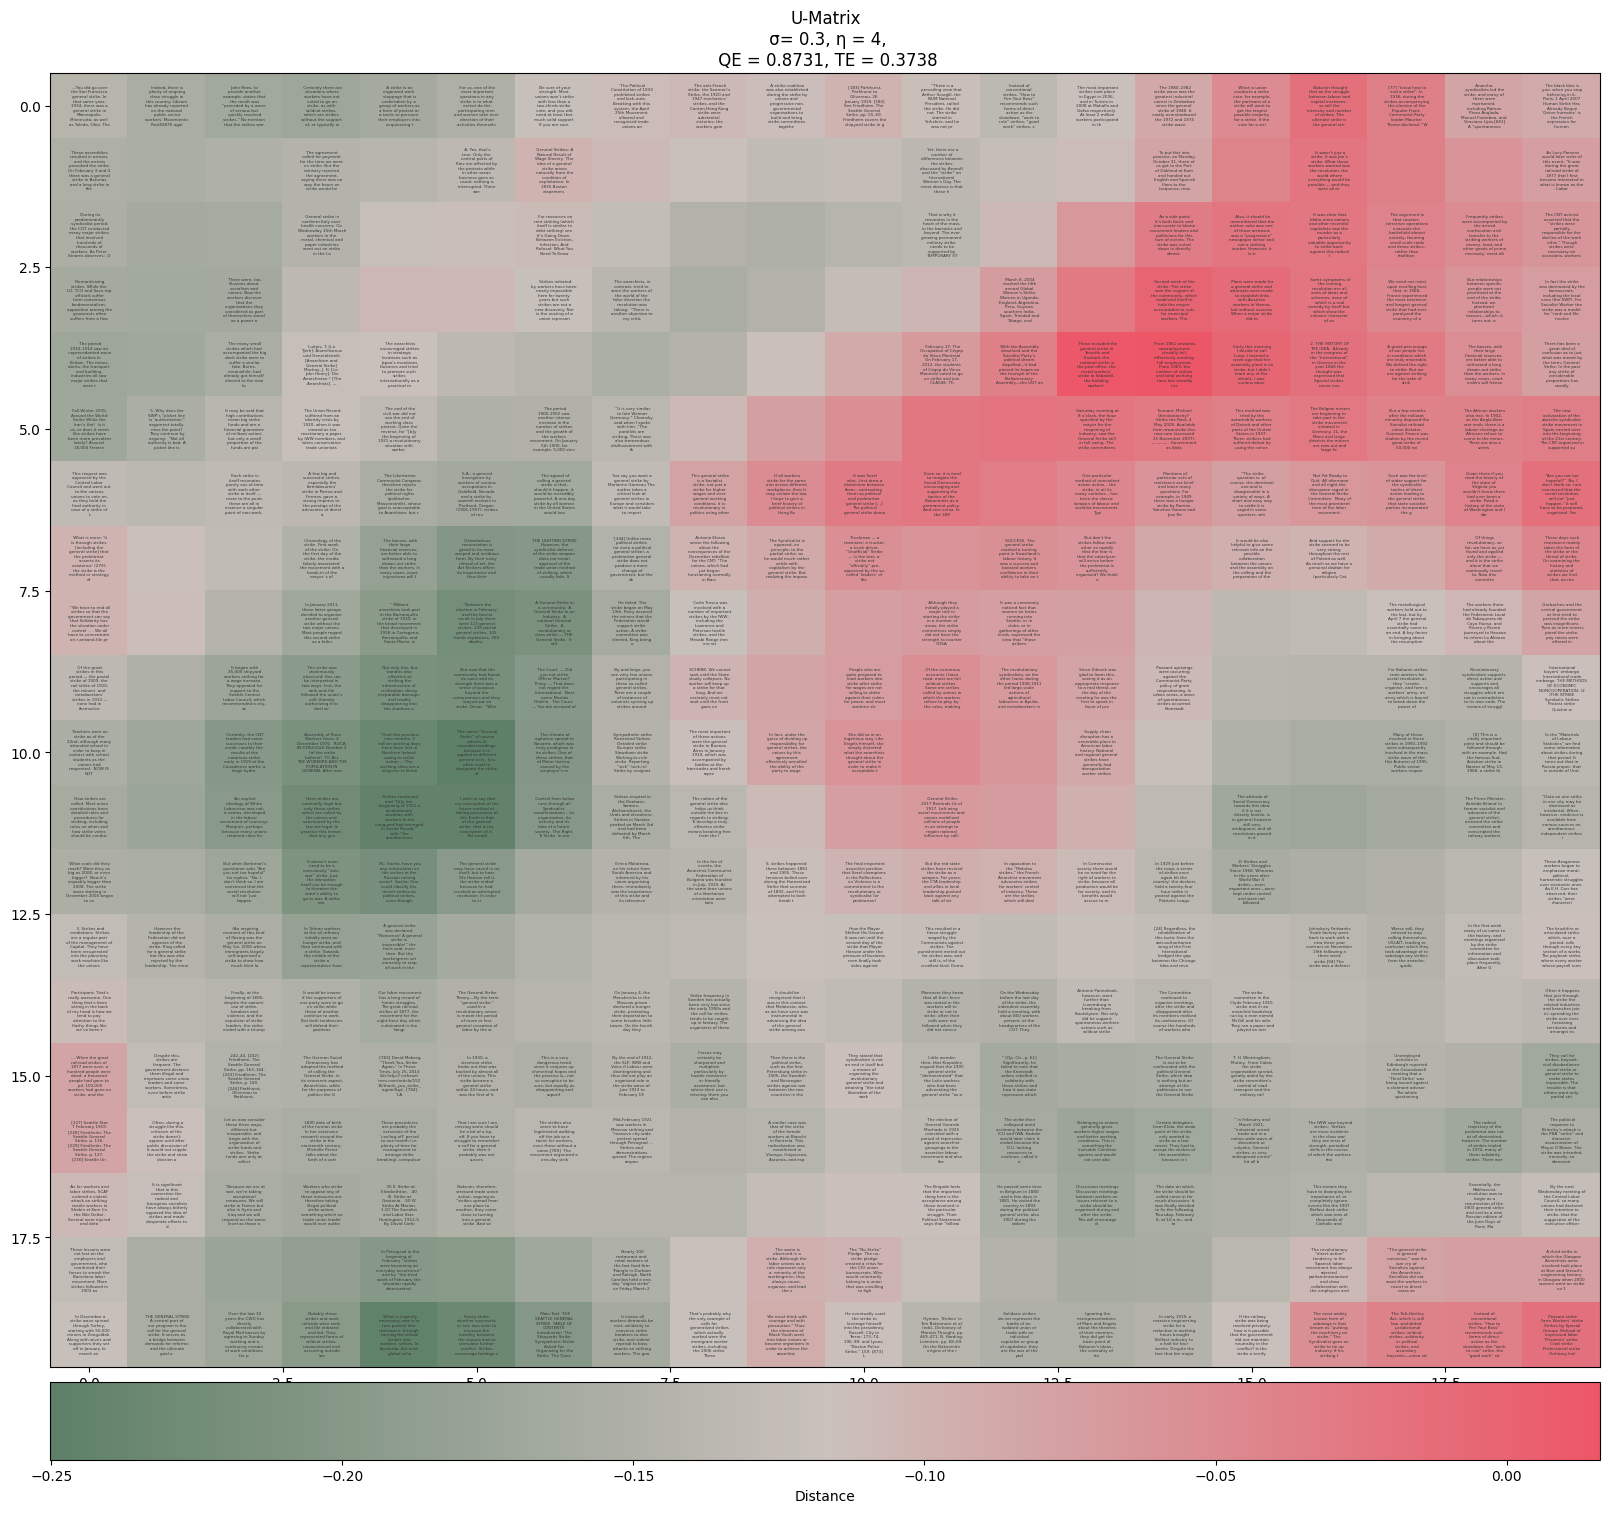

In [97]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(20, 20))
im = plt.imshow(activated_SOM01, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 3
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:160]  # Take the first xxx characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

# plt.savefig('SOM_Strike_Activated02.pdf', format='pdf')

# Show the plot
plt.show()

### Query 02

In [52]:
# Step 1: Convert the query word into vectors
query_word02 = 'government'  # Example query word
query_vector02 = model.infer_vector(word_tokenize(query_word02.lower()))  # Assuming 'model' is your Doc2Vec model

# Step 2: Activate the SOM using the activate function
activated_SOM02 = activate(train_data, SOM, query_vector02)

In [53]:
query_vector02[0]

0.012569365

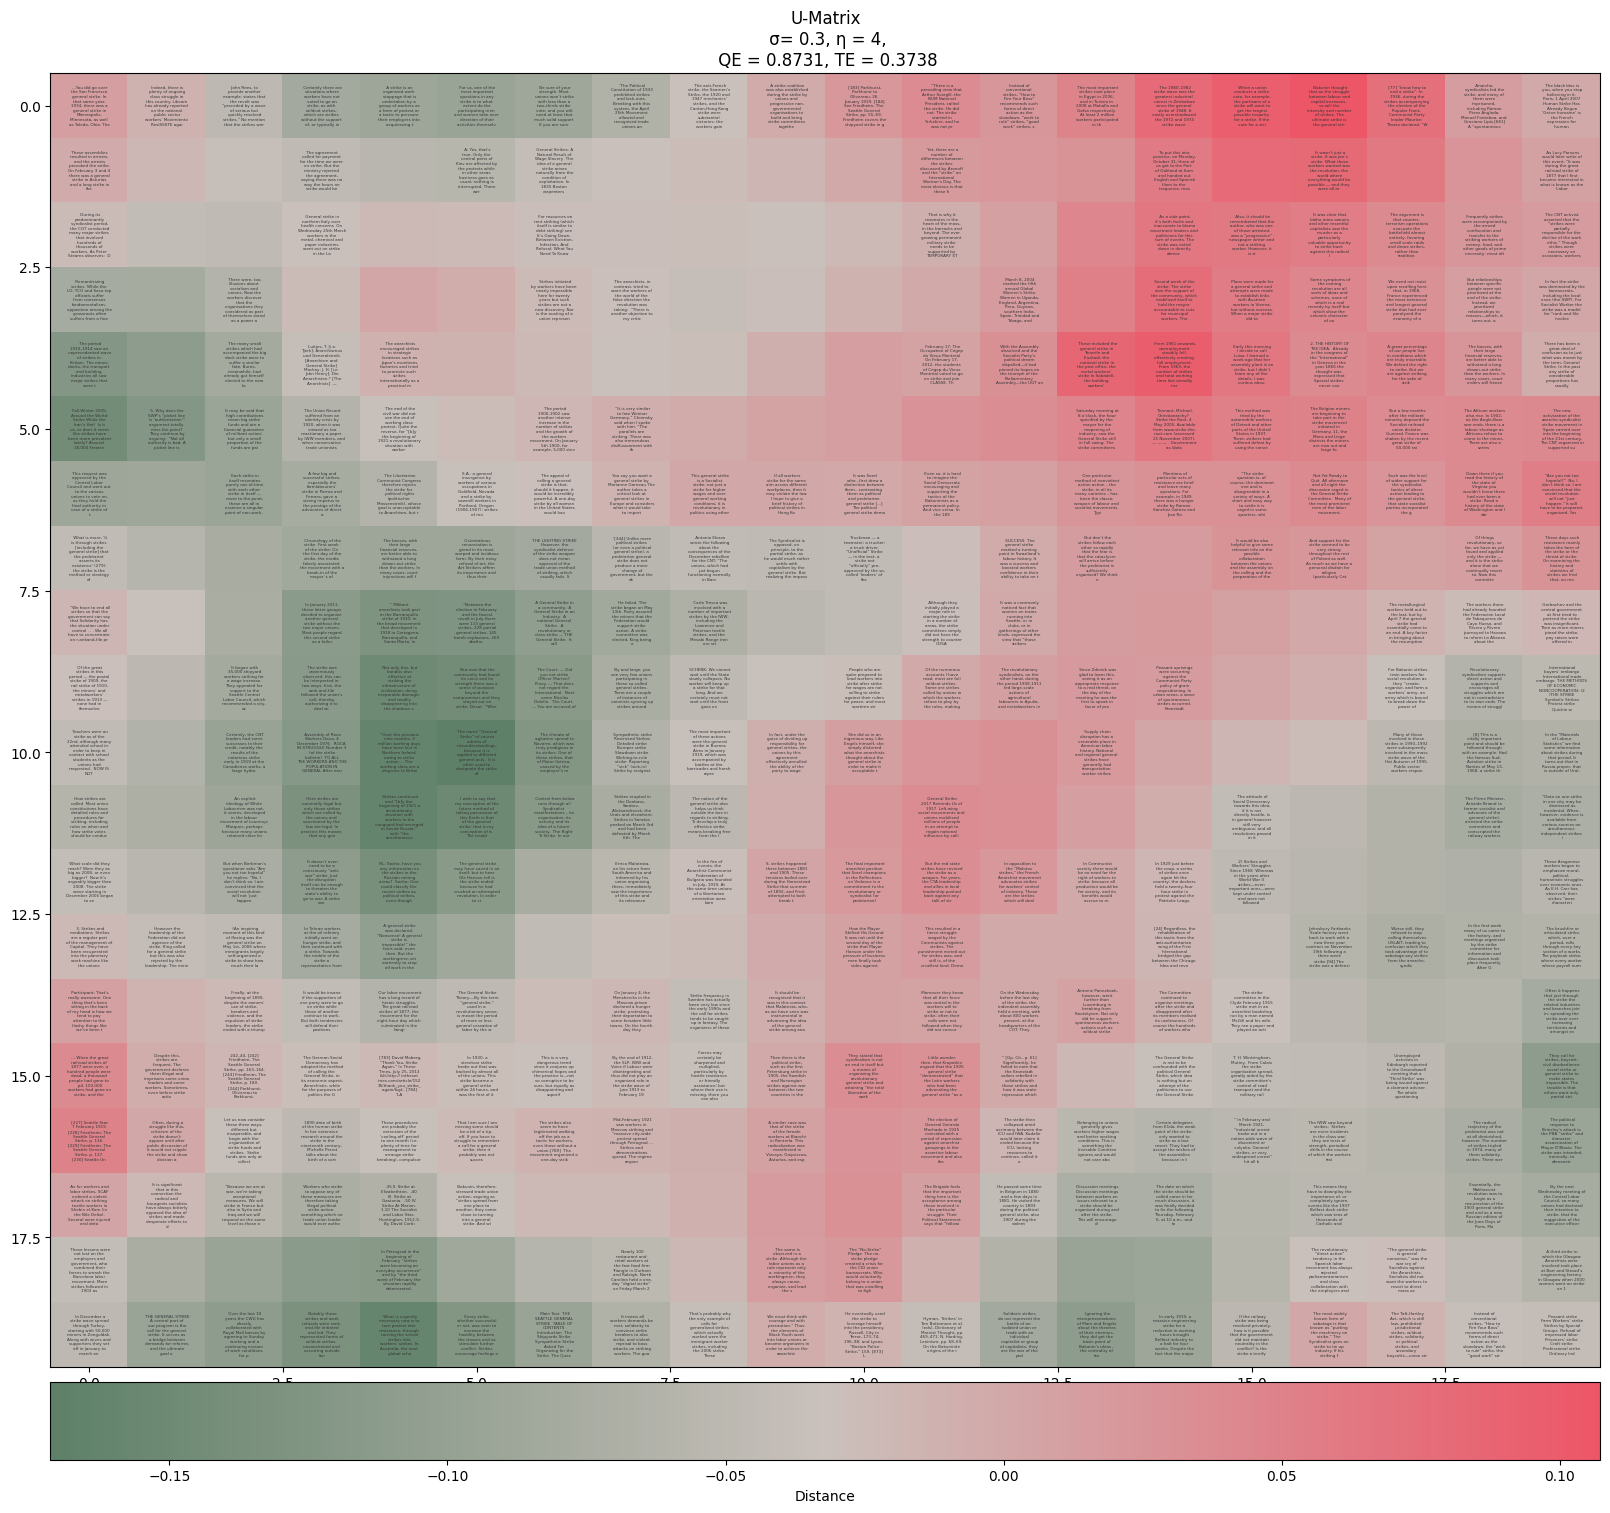

In [112]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(20, 20))
im = plt.imshow(activated_SOM02, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 3
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:160]  # Take the first xxx characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

# plt.savefig('SOM_Strike_Activated02.pdf', format='pdf')

# Show the plot
plt.show()

# Activate The SOM: Sentence

### Query 01

In [74]:
# Step 1: Convert the query sentences into vectors
query_sentences = ["the house"]
query_vectors = [model.infer_vector(word_tokenize(sentence.lower())) for sentence in query_sentences]


In [75]:
# Step 2: Activate the SOM using the activate function for each query vector
activated_SOMs = []
for query_vector in query_vectors:
    activated_SOM = activate(train_data, SOM, query_vector)
    activated_SOMs.append(activated_SOM)

# Step 2: Activate the SOM using the activate function
activated_SOM = activate(train_data, SOM, query_vector)

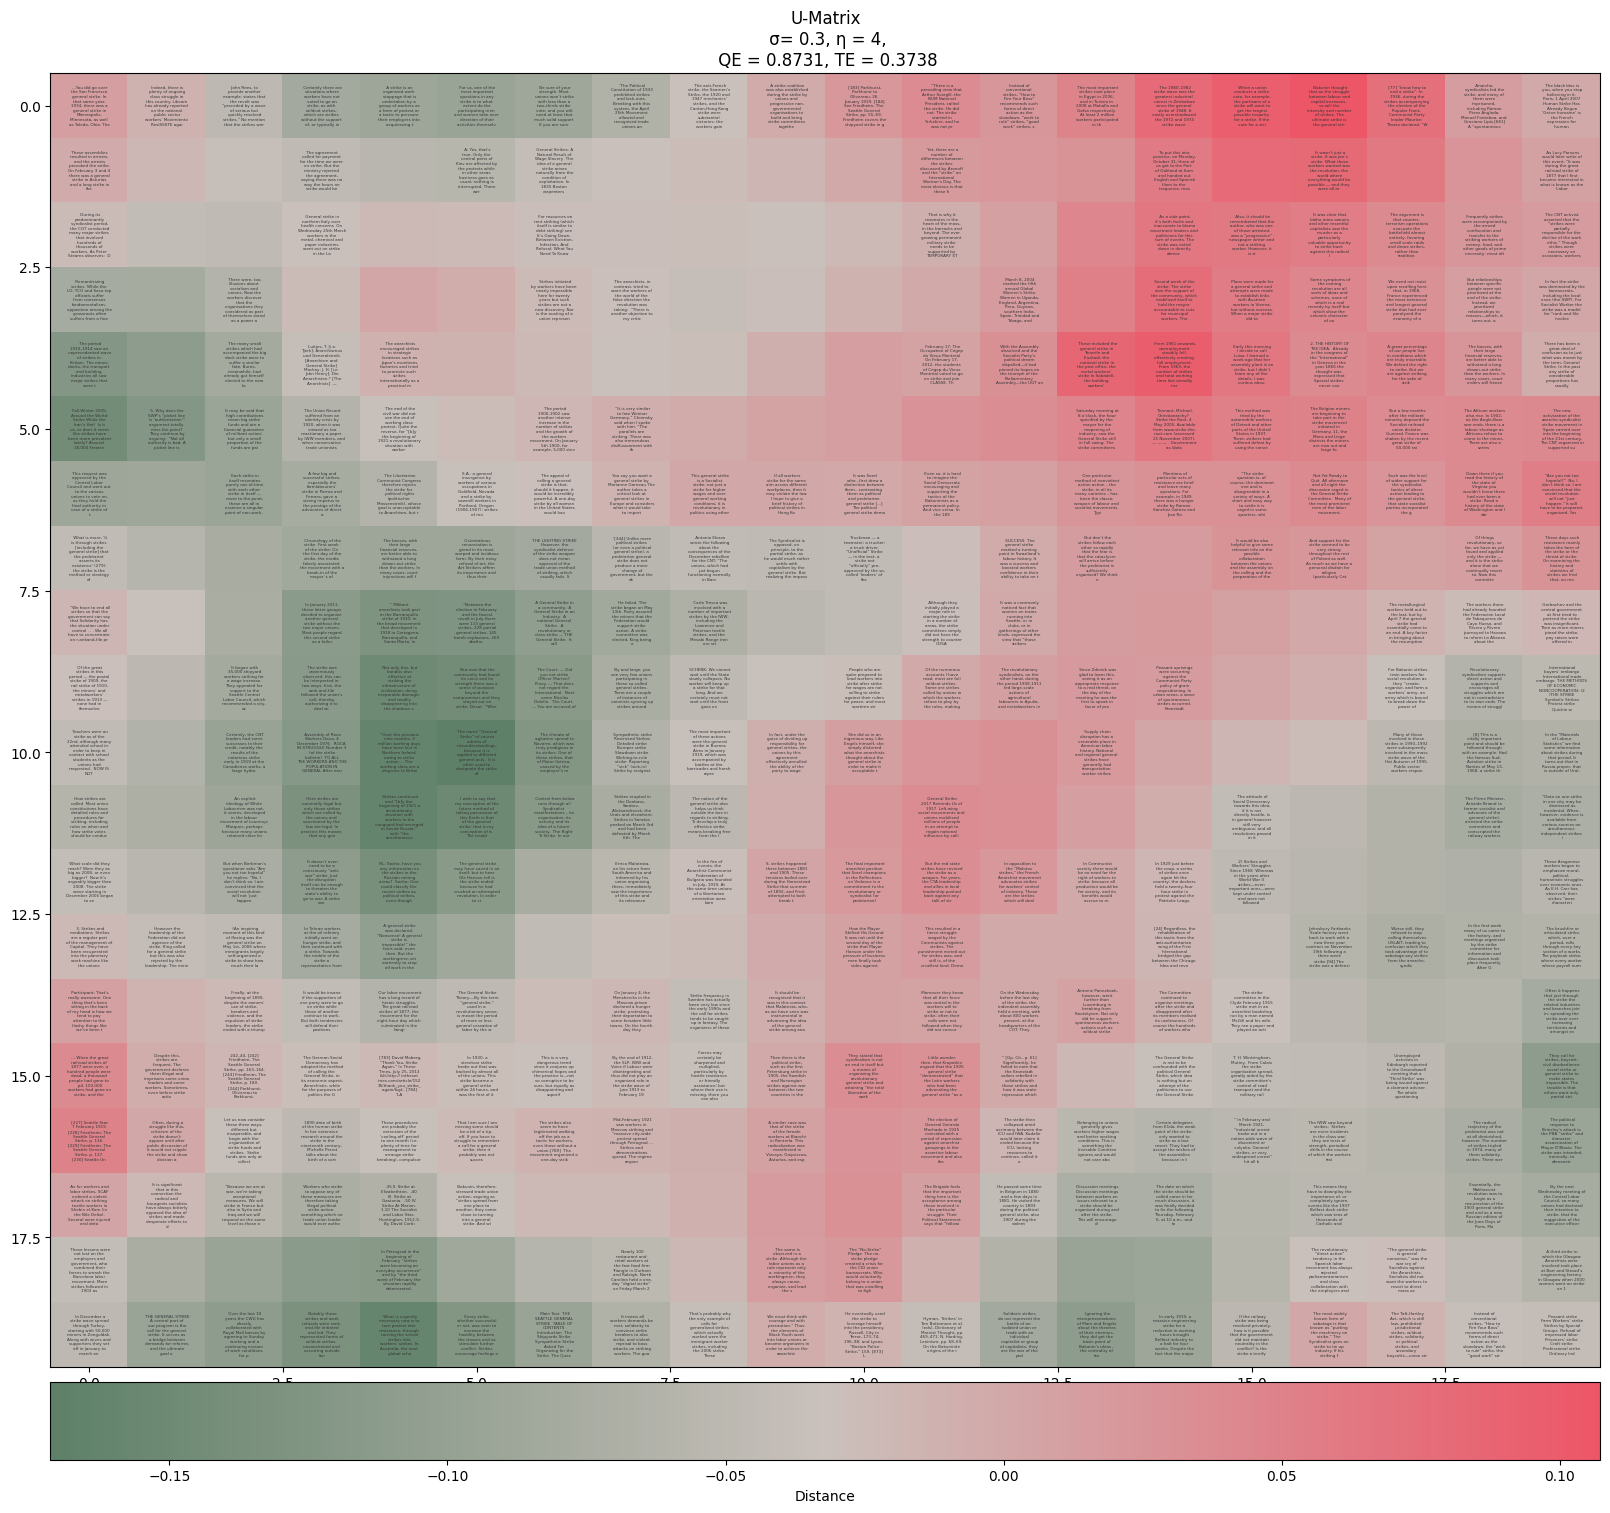

In [98]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(20, 20))
im = plt.imshow(activated_SOM02, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 3
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:160]  # Take the first xxx characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

# plt.savefig('SOM_Strike_Activated01.pdf', format='pdf')

# Show the plot
plt.show()

### Query 02

In [100]:
# Step 1: Convert the query sentences into vectors
query_sentences = ["the fire place"]
query_vectors = [model.infer_vector(word_tokenize(sentence.lower())) for sentence in query_sentences]


In [101]:
# Step 2: Activate the SOM using the activate function for each query vector
activated_SOMs = []
for query_vector in query_vectors:
    activated_SOM = activate(train_data, SOM, query_vector)
    activated_SOMs.append(activated_SOM)

# Step 2: Activate the SOM using the activate function
activated_SOM = activate(train_data, SOM, query_vector)

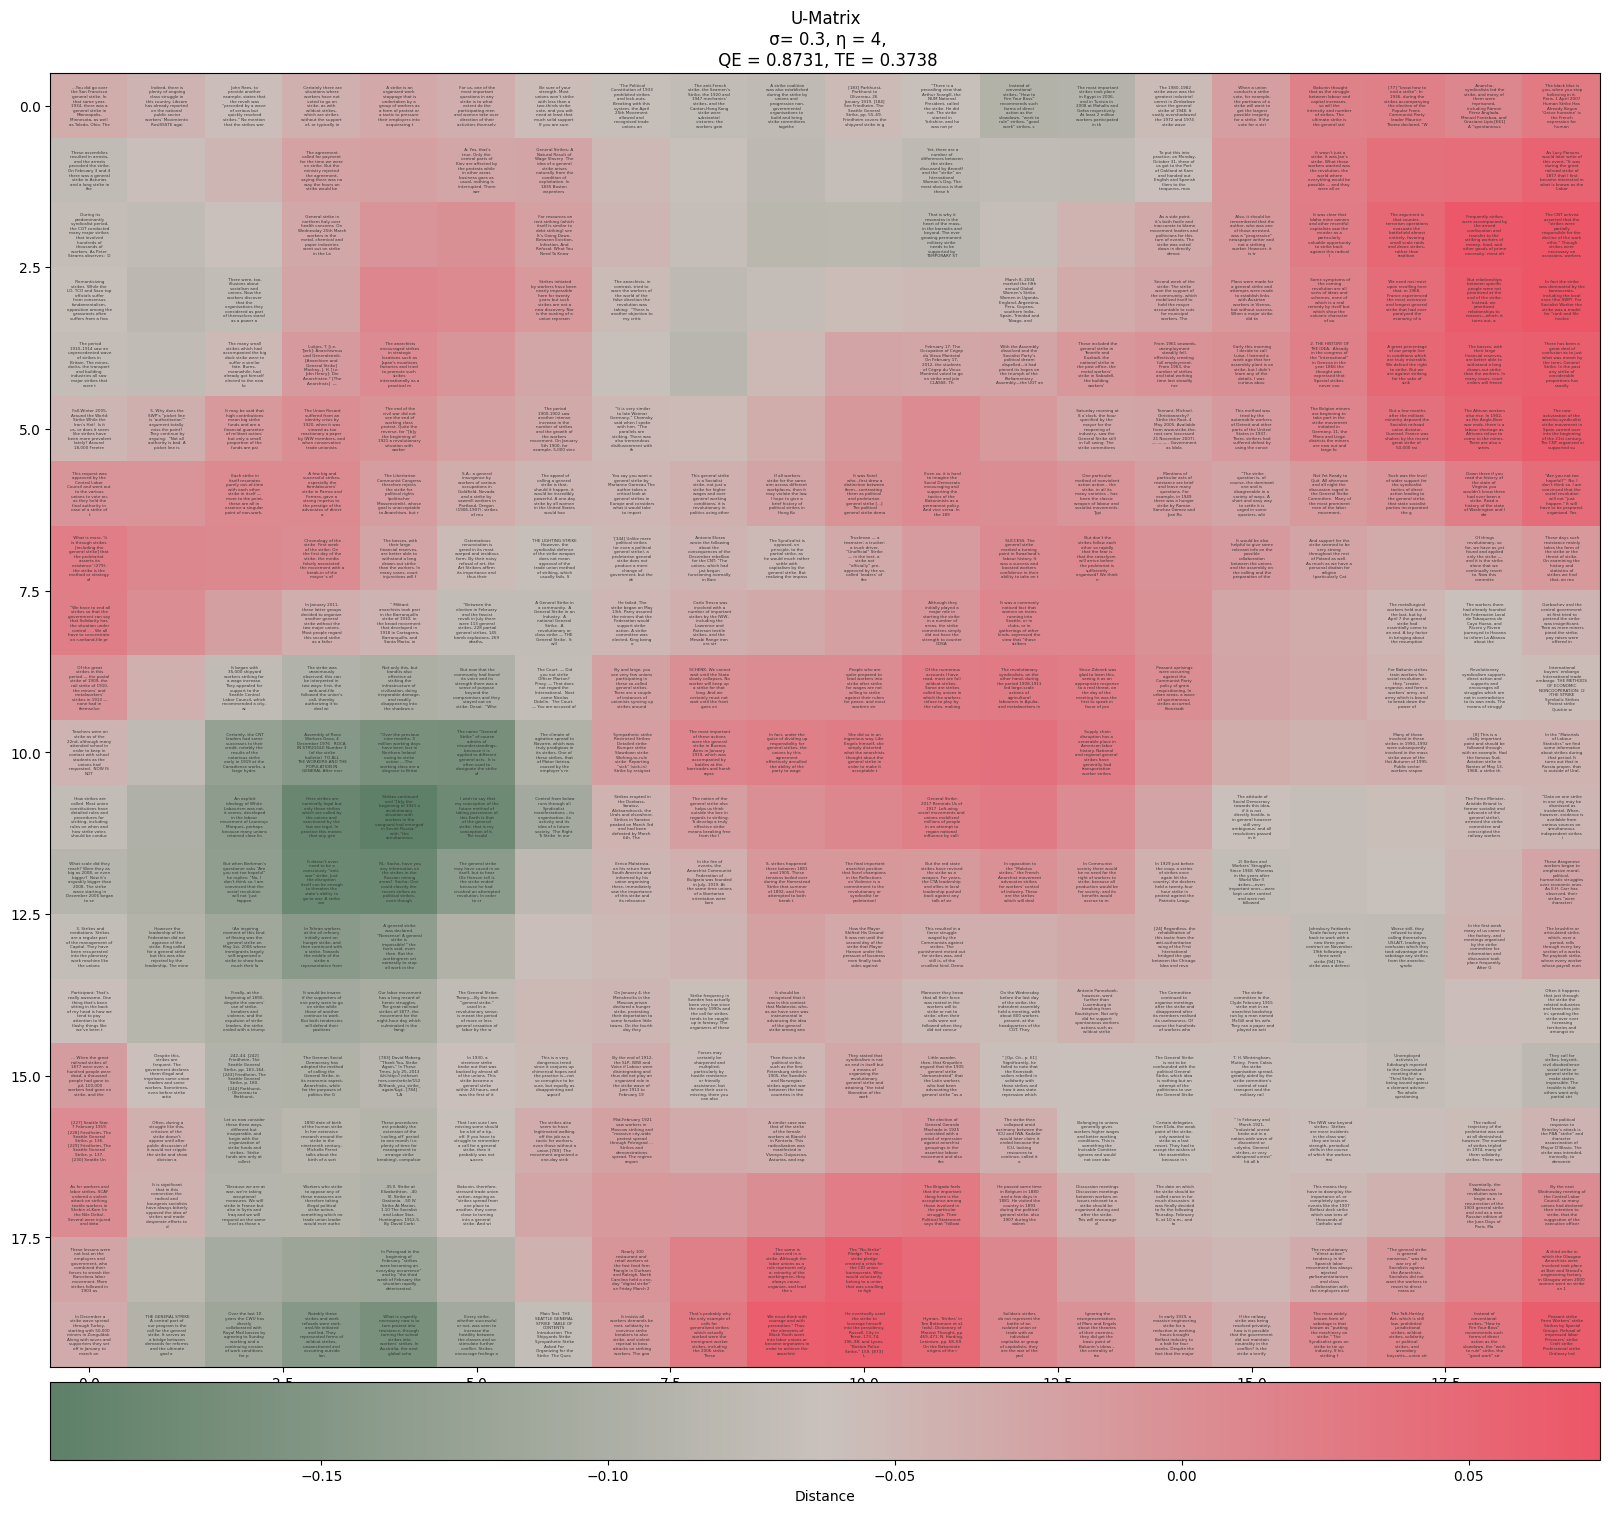

In [102]:
import textwrap

# Plot the U-Matrix and display the mapped sentences for each neuron
plt.figure(figsize=(20, 20))
im = plt.imshow(activated_SOM, cmap=cmap, aspect='auto')
plt.title(f'U-Matrix\n σ= {0.3}, η = {4},\n QE = {QE}, TE = {TE}')
plt.colorbar(im, orientation='horizontal', label='Distance', pad=0.01)

# Display only the first 100 characters of each sentence in each grid cell
for (i, j), sentences in neuron_sentence_mapping.items():
    if sentences:  # Check if there are sentences associated with the neuron
        # Reduce font size
        fontsize = 3
        # Select the first sentence associated with the neuron
        sentence = sentences[0][:160]  # Take the first xxx characters
        # Wrap the sentence to fit within the grid cell
        wrapped_sentence = "\n".join(textwrap.wrap(sentence, width=20))
        plt.text(j, i, wrapped_sentence, ha='center', va='center', color='#353637', fontsize=fontsize)

# plt.savefig('SOM_Strike_Activated02.pdf', format='pdf')

# Show the plot
plt.show()